12.Apply boosting, bagging, and random forests to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to simple methods like linear or logistic regression? Which of these approaches yields the best performance?

In [46]:
%load_ext autoreload
%autoreload 2
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tree plotting
import pydot
from IPython.display import Image
import graphviz 
#from sklearn.externals.six import StringIO  
from io import StringIO  

# Model selection
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Trees
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

%matplotlib inline
plt.style.use('seaborn-white')

In [48]:
# This function creates images of tree models using 'pydot' & 'export_graphviz'
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return (graph)

# Prints binary rules for a decision tree
# from: # https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
def tree_structure(clf):

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack` so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))

### 8.1.1 Regression Trees

In [49]:
import os 

UP_DIR = '/Users/isabellachittumuri/Documents/Hunter College/Fall 2020/Stat 724/Jupyter/'
csv_file = os.path.join(UP_DIR,'OJ.csv')

OJ = pd.read_csv(csv_file, header=0, index_col=0, squeeze=True)
OJ.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [50]:
# Make categorical outputs numerical
OJ['Store7'] = OJ.Store7.map({'Yes':1,'No':0})
OJ['Purchase'] = OJ.Purchase.map({'CH':1,'MM':0})
OJ['Purchase'].value_counts()

1    653
0    417
Name: Purchase, dtype: int64

In [51]:
OJ.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
1,1,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
2,1,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
3,1,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
4,0,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
5,1,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


In [52]:
X = OJ[['LoyalCH','PriceDiff']].values
y = np.log(OJ.Purchase.values)

<ipython-input-52-13f2246e517e>:2: RuntimeWarning: divide by zero encountered in log
  y = np.log(OJ.Purchase.values)


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1070, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [54]:
# Note: 80% of data in X_train, 20% of data in X_test
print('train size: {0}  test size {1}'.format(X_train.shape[0],X_test.shape[0]))

train size: 802  test size 268


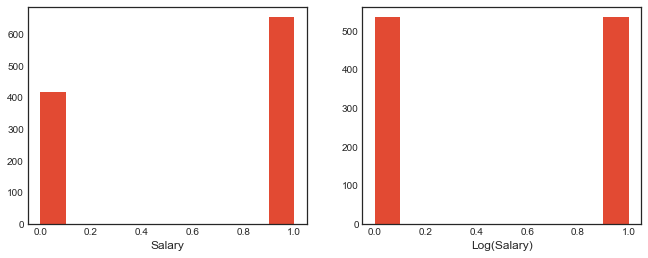

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(OJ.Purchase.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

In [56]:
# Tree with 3 leaf nodes. Note that we fix the random state (seed) for reproducibility.
regr = DecisionTreeRegressor(max_leaf_nodes=3, random_state=0)
regr.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3, random_state=0)

[Text(200.88000000000002, 181.2, 'X[1] <= 0.241\nmse = 0.25\nsamples = 1070\nvalue = 0.5'),
 Text(133.92000000000002, 108.72, 'X[0] <= -0.405\nmse = 0.138\nsamples = 522\nvalue = 0.835'),
 Text(66.96000000000001, 36.23999999999998, 'mse = 0.021\nsamples = 46\nvalue = 0.022'),
 Text(200.88000000000002, 36.23999999999998, 'mse = 0.079\nsamples = 476\nvalue = 0.914'),
 Text(267.84000000000003, 108.72, 'mse = 0.148\nsamples = 548\nvalue = 0.181')]

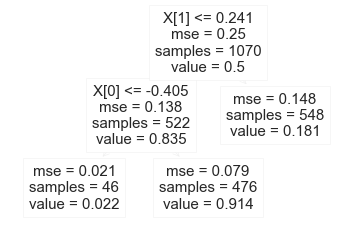

In [57]:
# Simple plot
import sklearn.tree as tree
tree.plot_tree(regr) 

In [58]:
# Understand the tree structure

tree_structure(regr)

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 1] <= 0.24060551822185516 else to node 2.
	node=1 is a split node: go to node 3 if X[:, 0] <= -0.4050930440425873 else to node 4.
	node=2 is a leaf node.
		node=3 is a leaf node.
		node=4 is a leaf node.


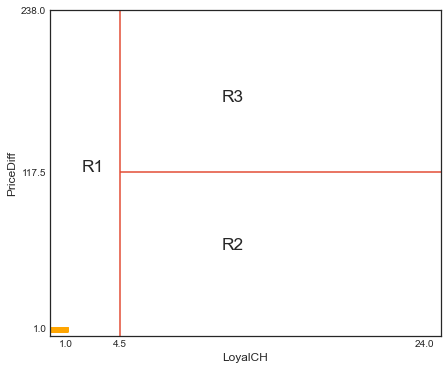

In [59]:
# Plot data partition into 3 regions

OJ.plot('LoyalCH','PriceDiff', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

### Pruning

In [60]:
# Split data to train and test and create a sequence of trees corresponding to sequence of values of 'alpha', the cost-complexity parameter (ccp):
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

regr2 = DecisionTreeRegressor(random_state=0)
path = regr2.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

**(a) "Impurity"**:  In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node. In the case of a regression tree, "impurity" is the MSE.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

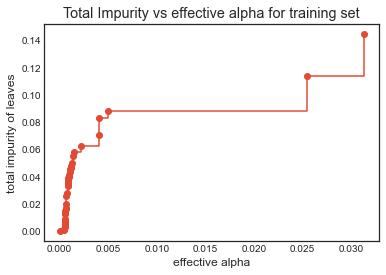

In [61]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [62]:
regs = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    reg.fit(X_train, y_train)
    regs.append(reg)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(regs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1048079331024522


**(b) Depth and number of nodes**: 
Here we show that the number of nodes and tree depth decreases as alpha increases.

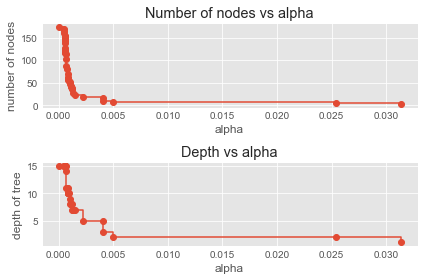

In [63]:
regs = regs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [reg.tree_.node_count for reg in regs]
depth = [reg.tree_.max_depth for reg in regs]

plt.style.use('ggplot')
# ax = plt.subplots(2, 1)
# figure = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

(c) Now, demonstrate **overfitting** by plotting the accuracy vs. alpha of trees built on train and test sets, respectively:

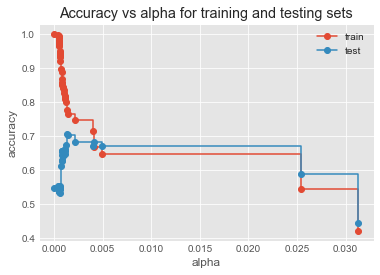

In [64]:
train_scores = [reg.score(X_train, y_train) for reg in regs]
test_scores = [reg.score(X_test, y_test) for reg in regs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")

ax.legend()
plt.show()

In [65]:
test_sc = np.array(test_scores)
ind_best = test_sc.argmax()
print(max(train_scores))
ccp_alphas[ind_best], test_sc[ind_best]

1.0


(0.0013374038719231097, 0.7064190546720284)

### Use CV to select best CCP

In [66]:
# Repeat the first step of prunning (see just before (a) above)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

regr2 = DecisionTreeRegressor(random_state=0)
path = regr2.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [67]:
# Function for fitting trees for diiferent values of the cost-complexity parameter (CCP) on the training data using cross-validation
def run_cv_on_trees(X, y, ccp_alphas, cv, scoring, treetype='classifier'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    scores = []
    
    i = 0
    for alpha in ccp_alphas:
        if treetype == 'classifier':
            tree_model = DecisionTreeClassifier(ccp_alpha=alpha)
            #scoring = 'accuracy' if scoring is None else scoring 
        else:
            tree_model = DecisionTreeRegressor(ccp_alpha=alpha)
            #scoring = 'mse' if scoring is None else scoring

        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        #if treetype=='regression':
        #    if i==0:
        #        cv_root = cv_scores 
        #    cv_scores = cv_scores/cv_root
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        scores.append(tree_model.fit(X, y).score(X, y))
        i+=1
        
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    scores = np.array(scores)
    return cv_scores_mean, cv_scores_std, scores

# function for plotting cross-validation results
def plot_cv_on_trees(ccp_alphas, cv_scores_mean, cv_scores_std, scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(ccp_alphas, cv_scores_mean, '-o', label='mean cross-validation score', alpha=0.9)
    ax.fill_between(ccp_alphas, cv_scores_mean-1*cv_scores_std, cv_scores_mean+1*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(ccp_alphas, scores, '-*', label='train score', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('CCP (alpha)', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(ccp_alphas)
    ax.legend()

In [68]:
# fitting multiple trees for each alpha
sm_ccp = ccp_alphas #range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_scores = run_cv_on_trees(X_train, y_train, sm_ccp, cv=10, scoring=None, treetype='regression')

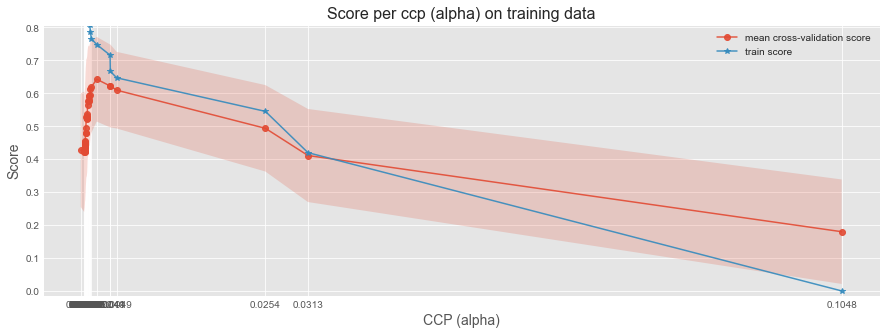

In [69]:
# plotting score (MSE or Accuracy)
plot_cv_on_trees(sm_ccp, sm_cv_scores_mean, sm_cv_scores_std, sm_scores, 'Score per ccp (alpha) on training data')

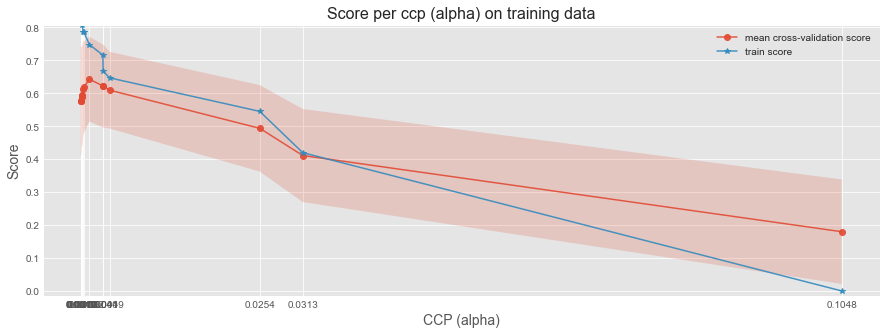

In [70]:
# Zoom in 
sm_ccp = ccp_alphas[-15:] #range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_scores = run_cv_on_trees(X_train, y_train, sm_ccp, cv=10, scoring=None, treetype='regression')
plot_cv_on_trees(sm_ccp, sm_cv_scores_mean, sm_cv_scores_std, sm_scores, 'Score per ccp (alpha) on training data')

In [71]:
idx_best = sm_cv_scores_mean.argmin()
best_alpha = sm_ccp[idx_best]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_best]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_best]
print('The tree with alpha={} at step={} achieves the best mean cross-validation score {} +/- {} on training dataset'.format(
      round(best_alpha,7), idx_best, round(sm_best_tree_cv_score, 5), round(sm_best_tree_cv_score_std, 5)))

The tree with alpha=0.1048079 at step=14 achieves the best mean cross-validation score 0.17976 +/- 0.1586 on training dataset
